# Diagonal Plus Low-Rank Gaussian Hidden Markov Model (HMM)

Hidden Markov Models (HMMs) assume that our $X$ observations can be explained by set of hidden state variable, $z$, each which can take on one of $K$ discrete values. 
That is, we assume that we have $z_t \in \{1, \ldots, K\}$, where $z_t = k$ denotes that the hidden variable is in state $k$ at time $t$.

We further assume that this hidden state evolves over time $t$ with some set of transition probabilities.
The key assumption in an HMM is that only the most recent state affects the next state: 

$$
p(z_t \mid z_{t-1}, z_{t-2}, \ldots, z_1) = p(z_t \mid z_{t-1})
$$

Importantly, we don't observe the state $z_t$ itself; instead, we get a noisy observation of the state at each time step according to some observation model.
We'll use $x_t$ to denote the observation at time step $t$ and use $D$ to refer to the dimensionality of the observation, since this can be either a vector or scalar.

In a Gaussian HMM, each discrete state $z_t = k$, is associated with a $D$-dimensional mean $\mu_k$ and covariance matrix $\Sigma_k$ which jointly determine the _emission probability distribution_. Thus, each probability distribution is a Gaussian centered at $\mu_k$ and with covariance $\Sigma_k$.

Diagonal plus low-rank Gaussian HMMs further assume that each covariance matrix of our Gaussian emission probabilities is _low-rank_; that is, that it can be well-modelled as a perturbation of a diagonal matrix.

## Applying diagonal plus low-rank Gaussian HMMs

Our goal in using diagonal plus low-rank Gaussian HMMs is to better reflect the our understanding of the underlying state dynamics&mdash;particularly when we believe several independent factors are involved.

In this tutorial, we'll explore these ideas in a two dimensional space for easy visualization.
First, we'll import the SSM-JAX library as well as a few other useful modules.

In [ ]:
try:
    import dynamax
except ModuleNotFoundError:
    print('installing dynamax')
    %pip install -qq git+https://github.com/probml/dynamax.git
    import dynamax

In [1]:
import jax.numpy as jnp
import jax.random as jr
from itertools import count

from dynamax.hidden_markov_model import LowRankGaussianHMM

Next, we need to define a diagonal plus low-rank Gaussian HMM instance.
To do this, we'll need to decide on the number of states $K$ in our model, as well as the dimensionality of our emission distributions, $D$.

In [2]:
# Global constants used to define the HMM
num_states = 3
emission_dim = 2
emission_cov_rank = 1

# Defined number of times to sample from the HMM
num_timesteps = 2000

# Set up an iterator to yield JAX PRNGKey's
keys = map(jr.PRNGKey, count())

From these, we can randomly initialize a Gaussian low-rank HMM instance.

In [3]:
lr_hmm = LowRankGaussianHMM(num_states, emission_dim, emission_cov_rank)
true_params, _ = lr_hmm.initialize(next(keys))
true_states, emissions = lr_hmm.sample(true_params, next(keys), num_timesteps)

After drawing 2000 samples from this diagonal plus low-rank Gaussian HMM, we have an array `true_states` of size $(2000,)$ which contains the true discrete state $z_t = k$ for each of our $t$ time steps.
We also have an array `emissions` of size $(2000, 2)$ which contains the 2000 observations from our diagonal plus low-rank Gaussian HMM, where each observation is of $D$ dimensions&mdash;in our case, two.

We'll next use these `true_states` and `emissions` variables to plot our emissions distributions, emphasizing the relationship between each emission feature across the $K$ (in our case, 3) states.

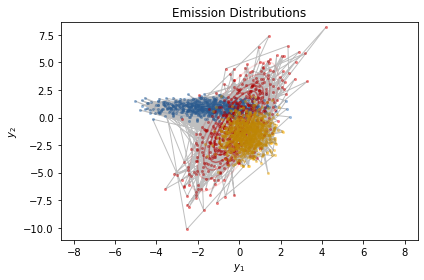

In [4]:
import matplotlib.pyplot as plt
from dynamax.plotting import COLORS
from dynamax.plotting import white_to_color_cmap

lim = 0.85 * abs(emissions).max()
XX, YY = jnp.meshgrid(jnp.linspace(-lim, lim, 100), jnp.linspace(-lim, lim, 100))
grid = jnp.column_stack((XX.ravel(), YY.ravel()))

plt.figure()
for k in range(lr_hmm.num_states):
    lls = lr_hmm.emission_distribution(true_params, k).log_prob(grid)
    plt.contour(XX, YY, jnp.exp(lls).reshape(XX.shape),
                cmap=white_to_color_cmap(COLORS[k]))
    plt.plot(emissions[true_states == k, 0],
             emissions[true_states == k, 1],
             "o", mfc=COLORS[k], mec="none", ms=3, alpha=0.5)

plt.plot(emissions[:, 0], emissions[:, 1], "-k", lw=1, alpha=0.25)
plt.xlabel("$y_1$")
plt.ylabel("$y_2$")
plt.title("Emission Distributions")
plt.tight_layout()

We can also plot the data superimposed on the generating state sequence to see the relationship between our each of the $D$ dimensions of our observations and the underlying states $K$ over time.

(0.0, 100.0)

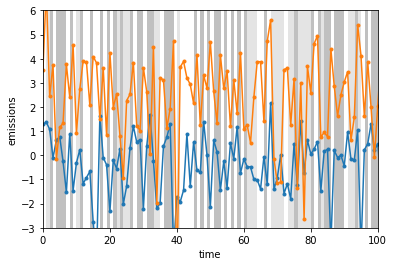

In [5]:
# Plot the emissions, along with the true states
fig, ax = plt.subplots()

offsets = 3 * jnp.arange(emission_dim)
ax.imshow(true_states[None, :],
              extent=(0, num_timesteps, -3, 3 * emission_dim),
              aspect="auto",
              cmap="Greys",
              alpha=0.25)
ax.plot(emissions + offsets, '-', marker='.')
ax.set_xlim(0, num_timesteps)
ax.set_ylim(-3, 3 * emission_dim)
ax.set_ylabel("emissions")
ax.set_xlabel("time")

# Zoom in on a smaller slice of data
ax.set_xlim(0, 100)

100%|██████████| 50/50 [00:03<00:00, 15.69it/s]


(0.0, 50.0)

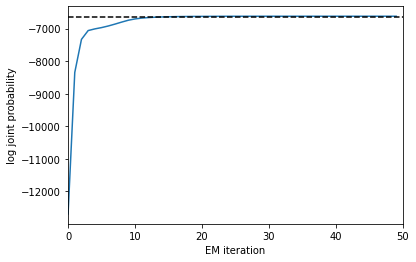

In [6]:
# Randomly initialize a second LowRankHMM
test_hmm = LowRankGaussianHMM(num_states, emission_dim, emission_cov_rank)
params, props = test_hmm.initialize(next(keys))

# To fit the model, give it a batch of emissions and a batch of corresponding features
params, lps = test_hmm.fit_em(params, props, emissions)

# Compute the marginal log probability of the emissions under the true model
true_lp = lr_hmm.marginal_log_prob(true_params, emissions)

# Plot the log probability over EM iterations
plt.figure()
plt.plot(lps)
plt.plot([0, len(lps)], true_lp * jnp.ones(2), '--k')
plt.xlabel("EM iteration")
plt.ylabel("log joint probability")
plt.xlim([0, len(lps)])


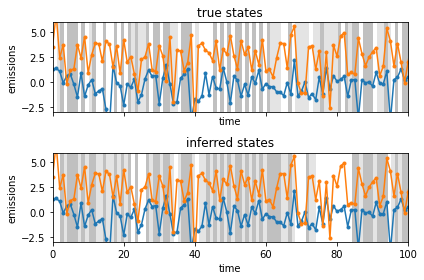

In [7]:
# Compute the most likely states
most_likely_states = test_hmm.most_likely_states(params, emissions)

# Compare them to the true states
fig, axs = plt.subplots(2, 1, sharex=True)

for i, states in enumerate([true_states, most_likely_states]):
    offsets = 3 * jnp.arange(emission_dim)
    axs[i].imshow(
        states[None, :],
        extent=(0, num_timesteps, -3, 3 * emission_dim),
        aspect="auto",
        cmap="Greys",
        alpha=0.25)
    axs[i].plot(emissions + offsets, '-', marker='.')
    axs[i].set_xlim(0, num_timesteps)
    axs[i].set_ylim(-3, 3 * emission_dim)
    axs[i].set_ylabel("emissions")
    axs[i].set_xlabel("time")
    axs[i].set_xlim(0, 100)

axs[0].set_title("true states")
axs[1].set_title("inferred states")
plt.tight_layout()

## Conclusions

This doesn't yet seem to work well.
We'll need to design a better simulation to showcase it !